# Introducing non-linear recharge models to Pastas
*R.A. Collenteur, University of Graz*

This notebook explains the use of the `RechargeModel` stress model to simulate the combined effect of precipitation and potential evapotranspiration on the groundwater levels. For the computation of the actual recharge, different (nonn-linear) models are available. The non-linear models were introduced in Pastas 0.14 as part of a publication by [Collenteur et al (in Prep.)][1].

**Note:** To run this notebook and the related non-linear recharge models, it is strongly recommended to install Numba (`pip install numba`, http://numba.pydata.org). This Just-In-Time (JIT) compiler compiles the computationally intensive part of the recharge calculation, making the model virtually as fast as the Linear recharge model.

### References

[1]:  Collenteur, R.A., Bakker, M., Birk, S., (in Prep.) Estimating groundwater recharge from observed groundwater levels using non-linear transfer function noise models.


In [1]:
import pandas as pd
import pastas as ps
import matplotlib.pyplot as plt

%matplotlib inline

## 1. Input data
Input data handling is similar to normal. The only thing that is necessary to check is that the precipitation and evaporation are provided in mm/day. This is necessary because the parameters for the unsaturated zone models are defined in mm for the length unit and days for the time unit. It is possible to use other units, but this would require manually setting the initial values and parameter boundaries.

In [2]:
head = pd.read_csv('../data/head_nb1.csv', parse_dates=['date'], index_col='date', squeeze=True)

# Make this millimeters per day
rain = pd.read_csv('../data/rain_nb1.csv', parse_dates=['date'], index_col='date', squeeze=True) * 1e3
evap = pd.read_csv('../data/evap_nb1.csv', parse_dates=['date'], index_col='date', squeeze=True) * 1e3

## 2. Make a basic model
1. Create a Pastas model
2. Choose and create a unsaturated zone model (you can choose from: `Linear`, `FlexModel`, and `Berendrecht`). All recharge models can be accessed through the recharge subpackage (`ps.rch`).
3. Create a `RechargeModel` object and add it to the model
4. Solve and visualize the model

INFO: Cannot determine frequency of series head
INFO: Inferred frequency from time series rain: freq=D 
INFO: Inferred frequency from time series evap: freq=D 


Model Results head                    Fit Statistics
nfev     40                     EVP            91.13
nobs     644                    R2              0.91
noise    True                   RMSE            0.13
tmin     1985-11-14 00:00:00    AIC            12.95
tmax     2015-06-28 00:00:00    BIC            48.69
freq     D                      ___                 
warmup   3650 days 00:00:00     ___                 
solver   LeastSquares           ___                 

Parameters (8 were optimized)
                optimal    stderr     initial   vary
rch_A          1.596847    ±5.80%    1.658231   True
rch_n          0.823089  ±344.41%    0.100000   True
rch_a          0.778287  ±327.38%   83.256795   True
rch_su       318.127379    ±2.49%  294.400660   True
rch_lp         0.250000     ±nan%    0.250000  False
rch_ks         1.000000    ±3.79%    1.000000   True
rch_gamma      1.133033    ±5.25%    1.130328   True
rch_si         2.000000     ±nan%    2.000000  False
constant_d    2

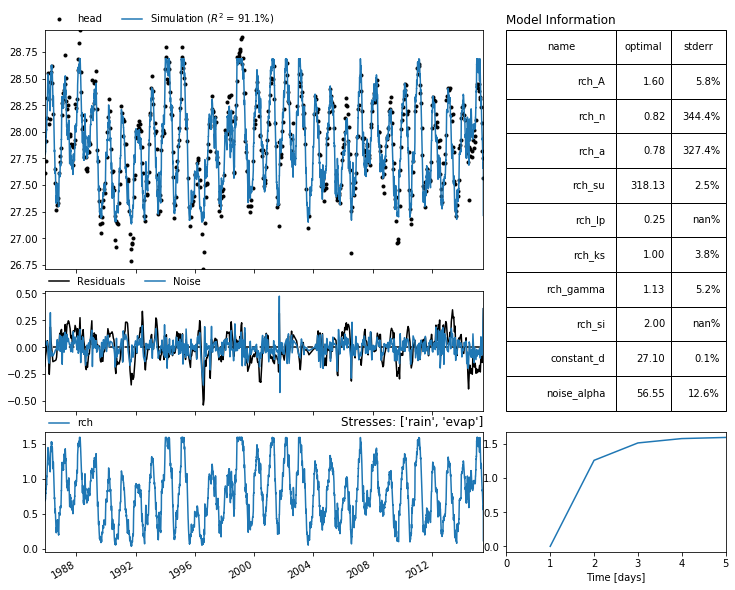

In [6]:
ml = ps.Model(head)

rch = ps.rch.FlexModel()
#rch = ps.rch.Berendrecht()
rm = ps.RechargeModel(rain, evap, recharge=rch, rfunc=ps.Gamma, name="rch")
ml.add_stressmodel(rm)
ml.solve(noise=False, report=False) #Getting some initial estimates without noisemodel can help
ml.solve(noise=True, initial=False)
ml.plots.results()

## 3. Analyze the estimated recharge flux
After the parameter estimation we can take a look at the recharge flux computed by the model. The flux is easy to obtain using the `get_stress` method of the model object, which automatically provides the optimal parameter values that were just estimated. After this, we can look at the recharge flux estimated by the Pastas model. 

Text(0, 0.5, 'Recharge [mm/year]')

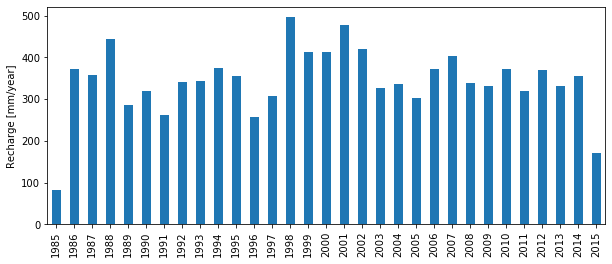

In [4]:
recharge = ml.get_stress("rch").resample("A").sum()
ax = recharge.plot.bar(figsize=(10,4))
ax.set_xticklabels(recharge.index.year)
plt.ylabel("Recharge [mm/year]")